Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [39]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

C:\Users\nelso\AppData\Local\Temp\ipykernel_6928\2552716592.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  'IsAccurate': np.bool8,


In [40]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    year_csv['Year'] = year
    data = pd.concat([
        data,
        year_csv
    ])

# Preprocessing

In [41]:
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': -1,
        'GapToLeader': -1,
        'IntervalToPositionAhead': -1,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1]

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder

In [42]:
def preprocess(df):
    print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    print('Datatypes processed...', df.shape)
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    df, encoder = process_feature_encoding(df)
    print('Features encoded...', df.shape)
    return df, encoder

In [43]:
df = data.copy()

In [44]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [45]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, encoder = preprocess(train_df)
test_df, _ = preprocess(test_df)

Preprocessing data... (70276, 28)


C:\Users\nelso\AppData\Local\Temp\ipykernel_6928\2062240116.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.zeros(6, dtype=np.bool8),


TrackStatus processed... (70276, 33)
Missing values processed... (67709, 33)
Datatypes processed... (67709, 33)
Target processed... (67709, 34)
Features removed... (67709, 21)
One hot :  (67709, 40)
Data :  (67709, 21)
Features encoded... (67709, 59)
Preprocessing data... (17569, 28)


c:\Users\nelso\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\nelso\AppData\Local\Temp\ipykernel_6928\2062240116.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.zeros(6, dtype=np.bool8),


TrackStatus processed... (17569, 33)
Missing values processed... (16921, 33)
Datatypes processed... (16921, 33)
Target processed... (16921, 34)
Features removed... (16921, 21)
One hot :  (16921, 40)
Data :  (16921, 21)
Features encoded... (16921, 59)


c:\Users\nelso\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

X_train = train_df.drop(['is_pitting'], axis=1)
y_train = train_df['is_pitting']

X_test = test_df.drop(['is_pitting'], axis=1)
y_test = test_df['is_pitting']

In [47]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(65245, 58) (16299, 58) (65245,) (16299,)


# Modelisation

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix

import tensorflow.keras.backend as K

def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return (specificity + sensitivity) / 2

def balanced_accuracy_loss(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    specificity = tn / (tn + fp + K.epsilon())
    sensitivity = tp / (tp + fn + K.epsilon())
    return (specificity + sensitivity) / 2

In [49]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [50]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.5151842961372035, 1: 16.964378575143005}

In [51]:
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_train.shape[1]
# Create model
model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='complexe_big_batch_size_lr05_drop2',)

from keras.optimizers import Adam

optimizer = Adam(
    learning_rate=0.0005
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[balanced_accuracy_loss]
    )

model.summary()

Model: "complexe_big_batch_size_lr05_drop2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              60416     
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (No

In [52]:
hist = model.fit(
    X_train, y_train, 
    epochs=800,
    batch_size=1024,
    validation_data=(X_test, y_test),
    class_weight=class_weights
)

Epoch 1/800
64/64 [==============================] - 2s 29ms/step - loss: 4.1480 - balanced_accuracy_loss: 0.4973 - val_loss: 1.5640 - val_balanced_accuracy_loss: 0.5021
Epoch 2/800
64/64 [==============================] - 2s 27ms/step - loss: 1.3157 - balanced_accuracy_loss: 0.4985 - val_loss: 0.8828 - val_balanced_accuracy_loss: 0.5009
Epoch 3/800
64/64 [==============================] - 2s 27ms/step - loss: 0.9585 - balanced_accuracy_loss: 0.4990 - val_loss: 0.8906 - val_balanced_accuracy_loss: 0.4985
Epoch 4/800
64/64 [==============================] - 2s 28ms/step - loss: 0.8420 - balanced_accuracy_loss: 0.5017 - val_loss: 0.7086 - val_balanced_accuracy_loss: 0.5004
Epoch 5/800
64/64 [==============================] - 2s 27ms/step - loss: 0.7717 - balanced_accuracy_loss: 0.5028 - val_loss: 0.9425 - val_balanced_accuracy_loss: 0.4998
Epoch 6/800
64/64 [==============================] - 2s 27ms/step - loss: 0.7583 - balanced_accuracy_loss: 0.5005 - val_loss: 0.9165 - val_balanced_ac

In [53]:
y_pred = model.predict(X_test)

510/510 [==============================] - 1s 1ms/step


In [54]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test, y_pred.round()))

[[11390  4417]
 [   57   435]]


              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84     15807
         1.0       0.09      0.88      0.16       492

    accuracy                           0.73     16299
   macro avg       0.54      0.80      0.50     16299
weighted avg       0.97      0.73      0.82     16299



In [55]:
import pickle
# Save model
models_dir = 'models/nn_complexe_big_batch_size_lr05drop2'
os.makedirs(models_dir, exist_ok=True)
model.save(os.path.join(models_dir, 'model.h5'))
encoder_path = os.path.join(models_dir, 'encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder, f)

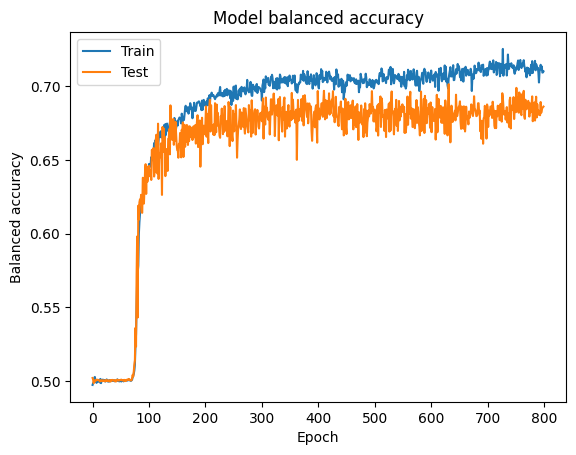

In [56]:
import matplotlib.pyplot as plt

plt.plot(hist.history['balanced_accuracy_loss'])
plt.plot(hist.history['val_balanced_accuracy_loss'])
plt.title('Model balanced accuracy')
plt.ylabel('Balanced accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(models_dir, 'balanced_accuracy.svg'), format='svg')
plt.show()